# Idiosyncratic Market Value Factor: 
# Explaining market value by machine learning methods

## Idea
At a given specific time point, market value explanition models think market values of listed firms can be explained by theirs financial informations and market factors.  
Under such assumptions, these models will induce an intrinsic market value of a listed firms at a specific time, however, there's always a residue term, which is also the difference between intrinsic value and current market value.  
We name this residue term as Idiosyncratic Market Value Factor, larger this factor is, indicating more upper bias is between current firm value and intrinsic value, by the idea of mean-reverting, it is more likely for the stock price to drop.  
In other words, this is a way of relative valuation and a smaller IMVF indicates a better performance of the stock. 

## Variables explanation
* $ m_{it} $ is the log-market value of stock $i$ at time $t$  
* $ IND_{it} $ is the dummy variables of different industries  
* $ b_{it} $ is the log-net asset of stock $i$ at time $t$, except firms whose net asset is negtive    
* $ Ln(NI)^+_{it}$ and $ Ln(NI)^-_{it}$ are net income of stock $i$ at time $t$ according to whether their sign  
* $ LEV_{it} $ is firm's financial leverage  
* $ g_{it} $ is the revenue growth rate (YoY quarterly)   
* $ RD_{it} $ is the log-R&D expense, None is replaced by 0  

# First sight: Linear Regression

Consider following model:  
$$ m_{it} = a_{0t}IND_{it}+a_{1t}b_{it}+a_{2t}Ln(NI)^+a_{3t}I_{<0}Ln(NI)^-_{it}+a_{4t}LEV_{it}+a_{5t}g_{it}+a_{6t}RD_{it}+\epsilon_{it} $$

## Machine Learning method: Random Forest
Consider Random Forest model:  
$$ m_{it} = RF(IND_{it},b_{it},Ln(NI)^,Ln(NI)^-_{it},LEV_{it},g_{it},RD_{it})+\epsilon_{it} $$

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [21]:
from quarter2month import quarter2month
from Winsorize_Fillna_Neutralize import Winsorize_Fillna_Neutralize
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor

## In this part, we will construct the idiosyncratic market value

### Load the raw data

In [9]:
# Input raw data
comp_frm=pd.read_csv('./data/industrycomp.csv')
netasset_raw=pd.read_excel('./data/netasset.xlsx')
netprofit_raw=pd.read_excel('./data/netprofit_q.xlsx')
lev_raw=pd.read_excel('./data/debt2asset.xlsx')
yoysales_raw=pd.read_excel('./data/yoysales.xlsx')
rd_raw=pd.read_excel('./data/rd.xlsx')
value_frm=pd.read_csv('./data/value.csv')
retf1_frm=pd.read_csv('./data/retf1.csv')
limit_status_frm=pd.read_csv('./data/limit_status_st.csv',encoding='gb18030')
tdate=list(value_frm['date'].drop_duplicates())

### Transform the seasonal data to monthly data

In [10]:
netasset_frm=quarter2month(tdate,netasset_raw,'netasset')
netprofit_frm=quarter2month(tdate,netprofit_raw,'netprofit')
lev_frm=quarter2month(tdate,lev_raw,'lev')
yoysales_frm=quarter2month(tdate,yoysales_raw,'yoysales')
rd_frm=quarter2month(tdate,rd_raw,'rd')

### Merge data

In [11]:
data=pd.merge(value_frm,netasset_frm,how='inner',on=['date','code'])
data=pd.merge(data,netprofit_frm,how='inner',on=['date','code'])
data=pd.merge(data,lev_frm,how='inner',on=['date','code'])
data=pd.merge(data,yoysales_frm,how='inner',on=['date','code'])
data=pd.merge(data,rd_frm,how='inner',on=['date','code'])
data=pd.merge(data,comp_frm,how='inner',on=['code'])
data=pd.merge(data,retf1_frm,how='inner',on=['date','code'])
data=pd.merge(data,limit_status_frm,how='inner',on=['date','code'])
data=data[['date','code','totalmv','netasset','netprofit','lev','yoysales','rd','industry','retf1','limit','status']]

In [17]:
data.head()

,date,code,totalmv,netasset,netprofit,lev,yoysales,rd,industry,retf1,limit,status,logmv,lognetasset,netprofit_abs,lognetprofit,ni_negative
121,20070131,000002.SZ,6.690315e+06,9.948030e+09,1.456485e+09,72.1260,50.5017,0.0,CI005023.WI,-0.037233,0.0,交易,15.716172,23.020640,1.456485e+09,21.099292,0.0
450,20070131,000006.SZ,3.025348e+05,1.236908e+09,1.772558e+08,55.7914,-20.4864,0.0,CI005023.WI,0.081375,0.0,交易,12.619952,20.935881,1.772558e+08,18.993104,0.0
573,20070131,000007.SZ,5.382492e+04,6.396426e+07,-2.582537e+07,88.7987,78.1794,0.0,CI005023.WI,0.294960,0.0,交易,10.893492,17.973835,2.582537e+07,17.066868,1.0
621,20070131,000008.SZ,4.124580e+04,7.230798e+07,-6.278618e+05,7.1045,-74.1205,0.0,CI005010.WI,0.143159,0.0,交易,10.627304,18.096445,6.278618e+05,13.350075,1.0
1036,20070131,000012.SZ,1.298777e+06,2.559077e+09,3.173672e+08,55.4746,28.0972,0.0,CI005008.WI,0.133759,0.0,交易,14.076934,21.662912,3.173672e+08,19.575570,0.0


### Construct responding variable

In [18]:
data=data.loc[np.where((~np.isnan(data['totalmv'])) & (~np.isnan(data['netasset'])) & (data['netasset']>0) & (~np.isnan(data['netprofit'])) & (~np.isnan(data['lev'])) & (~np.isnan(data['yoysales'])) & (~np.isnan(data['retf1'])) & (data['limit']==0) & (data['status']=='交易'))[0]]
data=data.reset_index(drop=True)
data['rd']=data['rd'].fillna(0)
data.loc[np.where(data['rd']>0)[0],'rd']=1
data['logmv']=np.log(data['totalmv'])
data['lognetasset']=np.log(data['netasset'])
data['netprofit_abs']=np.abs(data['netprofit'])
data['lognetprofit']=np.log(data['netprofit_abs'])
data.loc[np.where(data['netprofit']<0)[0],'ni_negative']=1
data['ni_negative']=data['ni_negative'].fillna(0)
data=data.sort_values(by=['date','code'],axis=0,ascending=True)
datadate=list(data['date'].drop_duplicates())

In [14]:
data.head()

,date,code,totalmv,netasset,netprofit,lev,yoysales,rd,industry,retf1,limit,status,logmv,lognetasset,netprofit_abs,lognetprofit,ni_negative
121,20070131,000002.SZ,6.690315e+06,9.948030e+09,1.456485e+09,72.1260,50.5017,0.0,CI005023.WI,-0.037233,0.0,交易,15.716172,23.020640,1.456485e+09,21.099292,0.0
450,20070131,000006.SZ,3.025348e+05,1.236908e+09,1.772558e+08,55.7914,-20.4864,0.0,CI005023.WI,0.081375,0.0,交易,12.619952,20.935881,1.772558e+08,18.993104,0.0
573,20070131,000007.SZ,5.382492e+04,6.396426e+07,-2.582537e+07,88.7987,78.1794,0.0,CI005023.WI,0.294960,0.0,交易,10.893492,17.973835,2.582537e+07,17.066868,1.0
621,20070131,000008.SZ,4.124580e+04,7.230798e+07,-6.278618e+05,7.1045,-74.1205,0.0,CI005010.WI,0.143159,0.0,交易,10.627304,18.096445,6.278618e+05,13.350075,1.0
1036,20070131,000012.SZ,1.298777e+06,2.559077e+09,3.173672e+08,55.4746,28.0972,0.0,CI005008.WI,0.133759,0.0,交易,14.076934,21.662912,3.173672e+08,19.575570,0.0


### Construct linear_IMV and randomforest_IMV

In [25]:
linear_params = []
rf_importance = []
r_squared = []
R_square_rf=[]
for i in range(len(datadate)):#
    print('Calculating Idiosyncratic Market Value in Period: '+str(datadate[i]))
    data_sel=data[data.date==datadate[i]]
    industrydummies=pd.get_dummies(data_sel['industry'])
    x_mat=pd.concat([industrydummies,data_sel['lognetasset'],data_sel['lognetprofit'],
                     data_sel['ni_negative']*data_sel['lognetprofit'],data_sel['lev'],data_sel['yoysales'],data_sel['rd']],axis=1)
    x=sm.add_constant(x_mat)
    y=np.array(data_sel['logmv'])
    model = sm.OLS(y,x)
    results = model.fit()
    data_sel['linear_spemv']=results.resid
    linear_params.append(pd.DataFrame(results.params,columns=[datadate[i]]))
    r_squared.append(results.rsquared)
    rf=RandomForestRegressor(n_estimators=500)
    rf.fit(x_mat,y)
    data_sel['rf_spemv']=y-rf.predict(x_mat)
    TSS=np.dot(y-np.mean(y),y-np.mean(y))
    ESS=np.dot(rf.predict(x_mat)-np.mean(y),rf.predict(x_mat)-np.mean(y))
    R_square_rf.append(ESS/TSS)
    rf_importance.append(pd.DataFrame(rf.feature_importances_,index=x_mat.columns,columns=[datadate[i]]))
    if i==0:
        data_new=data_sel
    else:
        data_new=pd.concat([data_new,data_sel],axis=0)

Calculating Idiosyncratic Market Value in Period: 20070131
Calculating Idiosyncratic Market Value in Period: 20070228
Calculating Idiosyncratic Market Value in Period: 20070330
Calculating Idiosyncratic Market Value in Period: 20070430
Calculating Idiosyncratic Market Value in Period: 20070531
Calculating Idiosyncratic Market Value in Period: 20070629
Calculating Idiosyncratic Market Value in Period: 20070731
Calculating Idiosyncratic Market Value in Period: 20070831
Calculating Idiosyncratic Market Value in Period: 20070928
Calculating Idiosyncratic Market Value in Period: 20071031
Calculating Idiosyncratic Market Value in Period: 20071130
Calculating Idiosyncratic Market Value in Period: 20071228
Calculating Idiosyncratic Market Value in Period: 20080131
Calculating Idiosyncratic Market Value in Period: 20080229
Calculating Idiosyncratic Market Value in Period: 20080331
Calculating Idiosyncratic Market Value in Period: 20080430
Calculating Idiosyncratic Market Value in Period: 200805

### The average of r_square in Linear model and RandomForest model

In [26]:
np.mean(r_squared)

0.7948704345688904

In [27]:
np.mean(R_square_rf)

0.8969009269123783

### Analyze the linear params significance and feature importance

In [28]:
lr_params = pd.concat(linear_params,axis=1).T
lr_params.index = pd.to_datetime([str(dt) for dt in lr_params.index])
rf_im=pd.concat(rf_importance,axis=1).T
rf_im.index = pd.to_datetime([str(dt) for dt in rf_im.index])

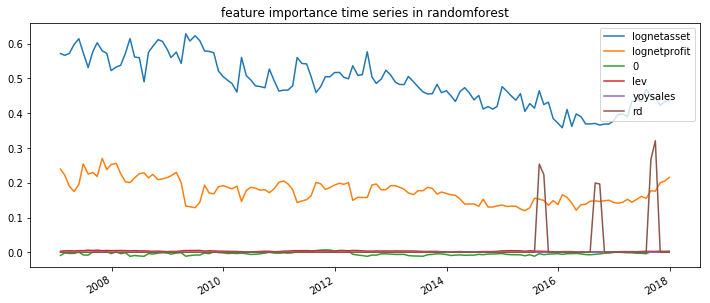

In [29]:
lr_params.iloc[:,-6:].plot(figsize=(12,5),title='feature importance time series in randomforest')

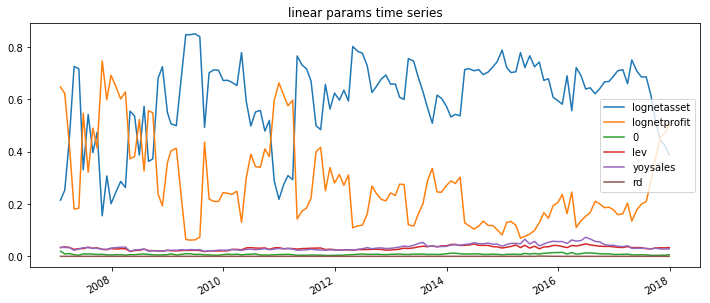

In [30]:
rf_im.iloc[:,-6:].plot(figsize=(12,5),title='linear params time series')

In [31]:
# calculate t-statistics
def t(s):
    dev = np.sqrt(np.power(s-s.mean(),2).sum()/(len(s)-1))
    return s.mean()/dev

### Linear model parameter significance and mean

In [32]:
lr_t = lr_params.iloc[:,-6:].agg([t,np.mean]).T

In [33]:
lr_t

,t,mean
lognetasset,7.063372,0.488900
lognetprofit,5.293597,0.175467
0,-0.898149,-0.003875
lev,2.334264,0.003085
yoysales,0.418659,0.000022
rd,0.213878,0.011065


### Random forest feature importance

In [34]:
rf_t = rf_im.iloc[:,-6:].apply(np.mean).T

In [35]:
pd.DataFrame(rf_t,columns=['feature_importance'])

,feature_importance
lognetasset,0.599446
lognetprofit,0.277495
0,0.007619
lev,0.031348
yoysales,0.034898
rd,0.000019


### Winsorize and Neutralize

In [36]:
# Factor processing
data_new=Winsorize_Fillna_Neutralize(data_new,'linear_spemv')
data_new=Winsorize_Fillna_Neutralize(data_new,'rf_spemv')
# data_new.to_csv('data2.csv',index=False)

In [37]:
data=pd.read_csv('./data/data3.csv',encoding='gb18030')
data.date = pd.to_datetime([str(dt) for dt in data.date])

In [38]:
data.head(3)

,date,code,totalmv,netasset,netprofit,lev,yoysales,rd,industry,retf1,limit,status,logmv,lognetasset,netprofit_abs,lognetprofit,ni_negative,linear_spemv,rf_spemv
0,2007-01-31,000002.SZ,6.690315e+06,9.948030e+09,1.456485e+09,72.1260,50.5017,0,CI005023.WI,-0.037233,0,交易,15.716172,23.020640,1.456485e+09,21.099292,0,0.039493,-1.000270
1,2007-01-31,000006.SZ,3.025348e+05,1.236908e+09,1.772558e+08,55.7914,-20.4864,0,CI005023.WI,0.081375,0,交易,12.619952,20.935881,1.772558e+08,18.993104,0,-1.233260,-0.932409
2,2007-01-31,000007.SZ,5.382492e+04,6.396426e+07,-2.582537e+07,88.7987,78.1794,0,CI005023.WI,0.294960,0,交易,10.893492,17.973835,2.582537e+07,17.066868,1,0.958505,-0.025166


## In second part, we will test the factors by IC and group backtest method

### Define IC method

In [39]:
def ic_timeseries(data,factor_name):
    
    assert('date' in data.columns)
    assert(factor_name in data.columns)
    
    dtList = list(data.date.drop_duplicates())
    rank_ic = []
    for dt in dtList:
        data1 = data[data.date == dt]
        rank_ic.append(data1[[factor_name,'retf1']].corr(method='spearman').values[0][1])

    return pd.DataFrame(rank_ic,index=dtList,columns=['ic']) 

In [40]:
def show_ic_analysis(data,factor_name):

    ic_ts = ic_timeseries(data,factor_name)
    
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)

    title1 = '%s IC time series' % factor_name
    ic_ts.plot(title=title1, ax=ax1)

    title2 = '%s IC histogram' % factor_name
    ic_ts.plot.hist(stacked=True, bins=20, title=title2, ax=ax2)

    title3 = '%s IC Box-plot' % factor_name
    ic_ts.plot.box(sym='r+', title=title3, ax=ax3)

    plt.tight_layout()
    plt.show()
    return 

### Define group backtest method

In [41]:
def group_backtest(data,factor_name,groups):
    
    assert('date' in data.columns)
    assert(factor_name in data.columns)
    
    gp_rets = {}
    benchmark_rets = {}
    
    dtList = list(data.date.drop_duplicates())
    for dt in dtList:
        df = data[data.date == dt]
        df['group'] = pd.qcut(df[factor_name], groups, labels=['Top%d' % i for i in range(1, groups + 1)])
        gp_rets[dt] = df.groupby(['group']).retf1.mean()
        benchmark_rets[dt] = df['retf1'].mean()
        
    rets_df = pd.DataFrame(gp_rets).T
    rets_df.columns = rets_df.columns.categories  #transform the CategoricalIndex to Index so that merge benchmark
    rets_df = pd.concat([rets_df,pd.DataFrame(benchmark_rets,index=['benchmark']).T],axis=1)
    rets_df['Top1/Top%d' % groups] =  rets_df.Top1 - rets_df['Top%d' % groups]
    rets_df['Top%d/benchmark' % groups] = rets_df['Top%d' % groups] - rets_df.benchmark
    rets_df['Top1/benchmark'] = rets_df['Top1'] - rets_df.benchmark
    rets_df = (rets_df+1).cumprod() 
    
    return rets_df

In [42]:
def show_group_analysis(data,factor_name,groups):
    
    col = ['Top%d' % i for i in range(1,groups+1)]
    col.extend(['benchmark'])
    pnls = group_backtest(data,factor_name,groups)
    pnls2 = pnls.loc[:, col]

    fig = plt.figure(figsize=(12, 15))
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)

    pnls2.plot(title='%s net value of different groups' % factor_name, ax=ax1)
    pnls2.iloc[:,:-1].div(pnls.benchmark,axis=0).plot(title='%s net value to benchmark' % factor_name, ax=ax2)
    pnls.loc[:,['Top1/Top%d' % groups]].plot(ax=ax3,title='%s Top1 Vs Top%d net value ratio' % (factor_name, groups))
    plt.tight_layout()
    plt.show()
    
    return